# Create train, test and validation dataframes


* Augmentation
* Normalization


In [1]:
import datetime
#from pathlib import Path
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import os.path
import numpy as np

# Input File Selection and Directory Setup

In [2]:
# Input file can be varied to point to different files.
# However, this model assumes these columns:
#  Z (Target) 
#  X (Feature 1 or X_1)
#  Y (Feature 1 or X_2)
#  ... (Feature N)
#
# For this demo, it was three columns where:
#    where z = x + y

# sample data for easy x+y=z
# JUST z=10
#CSV_FILE_NAME = "xyz10.csv"

# sample data for easy x+y=z
CSV_FILE_NAME = "xyz.csv"

os.environ['CSV_FILE_NAME'] = CSV_FILE_NAME

In [3]:
# The current directory will be where this src file is located.
# Which is in the src dir of the project
dirpath = os.getcwd()
print("current directory is : " + dirpath)

current directory is : /Users/davis/progs/github/Keras-Philosophy/notebooks


In [4]:
# Use pathlib to find the root dir of the git repo
root_path = pathlib.PurePath(dirpath).parents[0]
data_path = root_path / 'data'
logs_path = root_path / 'logs'
print("root directory is: ", root_path)
print("data directory is: ",  data_path)
print("logs directory is: ", logs_path)

root directory is:  /Users/davis/progs/github/Keras-Philosophy
data directory is:  /Users/davis/progs/github/Keras-Philosophy/data
logs directory is:  /Users/davis/progs/github/Keras-Philosophy/logs


In [5]:
# Create equivalent dir names in the environment
# Logs
LOGS_DIR_NAME = logs_path.as_posix()
print("LOGS_DIR_NAME: ", LOGS_DIR_NAME)
os.environ['LOGS_DIR_NAME'] = LOGS_DIR_NAME
# Data
DATA_DIR_NAME = data_path.as_posix()
print("DATA_DIR_NAME: ", DATA_DIR_NAME)
os.environ['DATA_DIR_NAME'] = DATA_DIR_NAME

LOGS_DIR_NAME:  /Users/davis/progs/github/Keras-Philosophy/logs
DATA_DIR_NAME:  /Users/davis/progs/github/Keras-Philosophy/data


In [6]:
%%bash
head -n 5 "${DATA_DIR_NAME}/${CSV_FILE_NAME}"

z,x,y
10.0,10.0,0.0
10.0,9.0,1.0
10.0,8.0,2.0
10.0,7.0,3.0


# Use pandas to read csv into dataframe

In [7]:
raw_dataframe = pd.read_csv(data_path / CSV_FILE_NAME, 
                          header=0,
                          sep=",")

dataframe = raw_dataframe.copy()

In [8]:
dataframe.shape
dataframe.head()

,z,x,y
0,10.0,10.0,0.0
1,10.0,9.0,1.0
2,10.0,8.0,2.0
3,10.0,7.0,3.0
4,10.0,6.0,4.0


# Plot the data

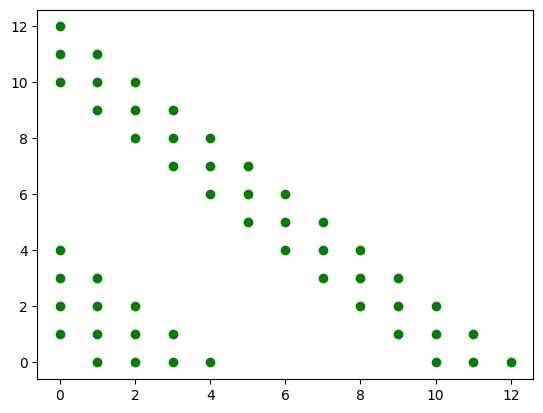

In [9]:
plt.scatter(dataframe['y'], dataframe['x'], c='green')

# Augment the data

Increase the size of the existing dataset by creating a new copy.  In the copy add tiny amount to x column and then subtract the same amount to the y column so that the sum remains constant.  Dupe this process 100 times.

In [10]:
# create a routine to augment an existing df
def create_aug_df(a_df): 

    copy_df = a_df.copy()

    # drop rows with zero in X
    copy_df = copy_df[copy_df.x != 0]

    # drop rows with zero in y
    copy_df = copy_df[copy_df.y != 0]

    # so we don't introduce negative numbers, get the minimum and set that 
    # as the floor. 
    min_val = copy_df.min(axis=None)
    rnd_val = np.random.rand()
    mod_val = np.minimum(min_val, rnd_val)
    #print("min_value: ",min_val)
    #print("mod_value: ", mod_val)

    # adj columns x and y by mod amount
    copy_df['x'] = copy_df['x'] + mod_val
    copy_df['y'] = copy_df['y'] - mod_val

    return copy_df


In [11]:
# use the function to create a larger augmented dataframe
df_list = []
for x in range(0,10):
    df_list.append(create_aug_df(dataframe))

aug_df = pd.concat(df_list)
#print("augmented df shape: ", aug_df.shape)
#print("aug_df head: ")
#print(aug_df.head())

# Plot the Data

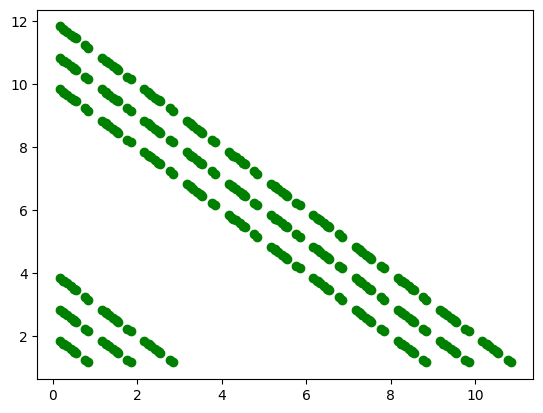

In [12]:
plt.scatter(aug_df['y'], aug_df['x'], c='green')

# Create Train, Test and Validation DataFrames

In [13]:
# Since we used concat, our index is screwed uup
# create a new index and apply it
num_rows = aug_df.shape[0]
index = pd.Index(range(0,num_rows))
aug_df.set_index(index,inplace=True)


In [14]:



# sample 70% of aumented data to the train_df
train_df = aug_df.sample(frac=0.7,random_state=3367)

# what's leftover will be split into test and train evenly
leftover_df = aug_df.drop(train_df.index) 

# split what's leftover into test and validation                       
test_df = leftover_df.sample(frac=0.5, random_state=3367)
valid_df = leftover_df.drop(test_df.index)

# print sizes as check
print("train shape: ", train_df.shape)
print("test shape: ", test_df.shape)
print("valid shape: ", valid_df.shape)



train shape:  (252, 3)
test shape:  (54, 3)
valid shape:  (54, 3)


# Plot the Data

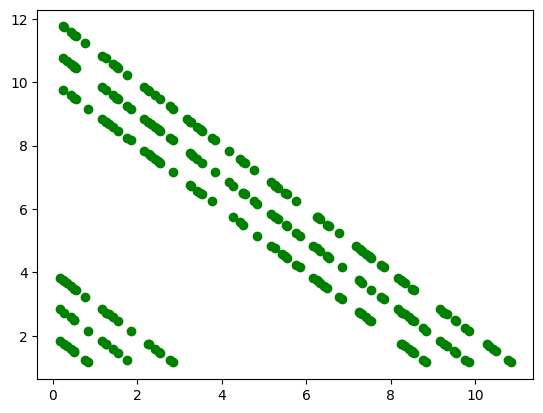

In [15]:
plt.scatter(train_df['y'], train_df['x'], c='green')

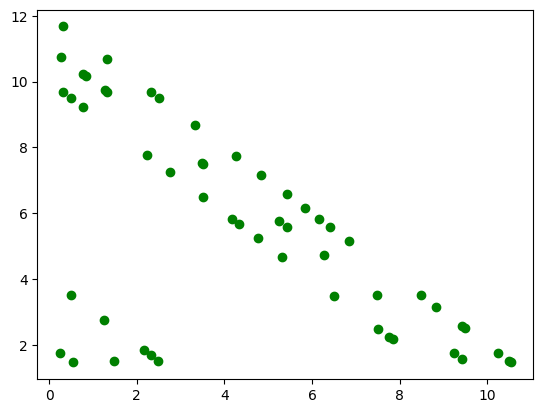

In [16]:
plt.scatter(valid_df['y'], valid_df['x'], c='green')

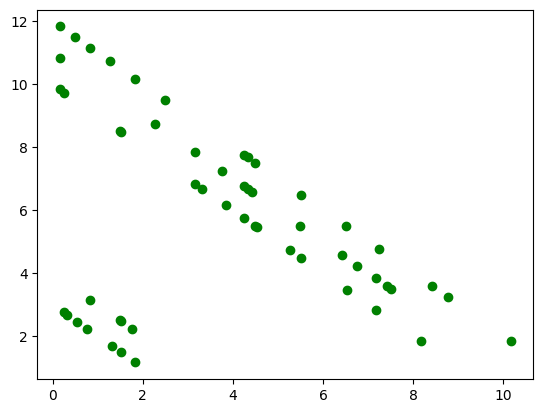

In [17]:
plt.scatter(test_df['y'], test_df['x'], c='green')

In [18]:
train_df

,z,x,y
262,11.0,9.160482,1.839518
4,10.0,5.490811,4.509189
207,12.0,3.460111,8.539889
326,10.0,7.674466,2.325534
161,11.0,2.237305,8.762695
...,...,...,...
286,4.0,2.160482,1.839518
201,12.0,9.460111,2.539889
160,11.0,3.237305,7.762695
282,2.0,1.160482,0.839518


# Standardize the Data

Standardize the training data such that all values are in range [-1,1].

Since you are not supposed to know what the data is for prediction, don't standardize
that data until you use it.  And, when you do, use the same values that you used
for training set.  Afterwards, reverse it when you get prediction to map back
into test space.

In [19]:
train_stats_df = train_df.copy()
train_stats_df = train_stats_df.describe().transpose()
train_stats_df

,count,mean,std,min,25%,50%,75%,max
z,252.0,9.809524,2.977242,2.000000,10.000000,11.000000,12.000000,12.000000
x,252.0,5.358895,3.062602,1.160482,2.578992,4.745056,8.160482,11.755098
y,252.0,4.450629,3.098424,0.163663,1.539889,4.001590,7.264986,10.839518


In [20]:

# Note, if you have a column which has STD of 0, this will have problems
# For instance, xyz10 will add NaN for Z using this method.  Likewise,
# the constant value for z and the mean will be identical.  Also
# adding to problem. 

def standardize(a_df):
    standardized_df = (a_df - train_stats_df['mean']) / train_stats_df['std']
    return standardized_df

std_train_df =  standardize(train_df)
std_valid_df =  standardize(valid_df)
std_test_df =  standardize(test_df)

In [21]:
std_train_df

,z,x,y
262,0.399859,1.241293,-0.842722
4,0.063977,0.043073,0.018900
207,0.735740,-0.619990,1.319787
326,0.063977,0.756080,-0.685863
161,0.399859,-1.019261,1.391696
...,...,...,...
286,-1.951310,-1.044345,-0.842722
201,0.735740,1.339128,-0.616681
160,0.399859,-0.692741,1.068952
282,-2.623073,-1.370865,-1.165467


# Plot the data

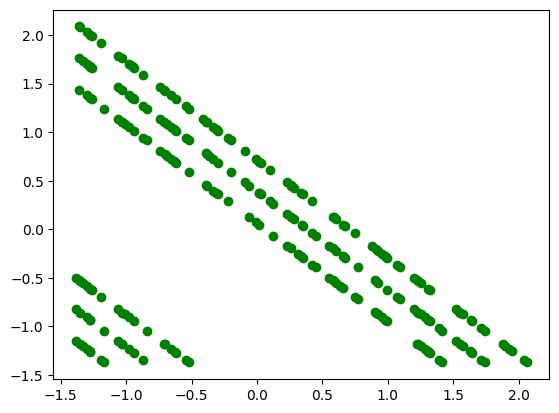

In [22]:
plt.scatter(std_train_df['y'], std_train_df['x'], c='green')

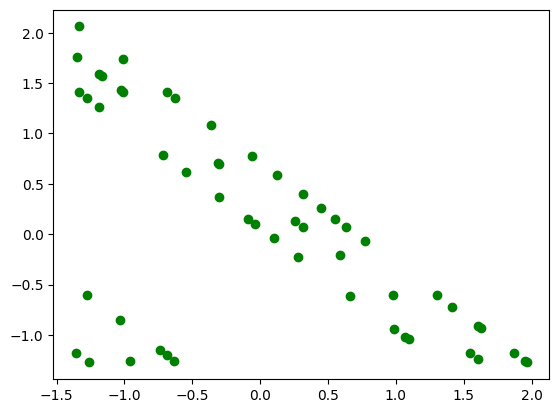

In [23]:
plt.scatter(std_valid_df['y'], std_valid_df['x'], c='green')

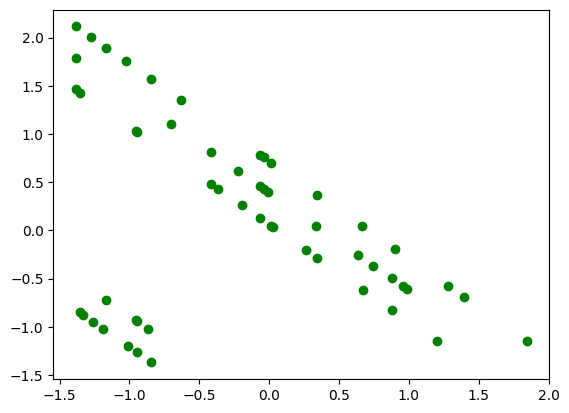

In [24]:
plt.scatter(std_test_df['y'], std_test_df['x'], c='green')

# write the dataframes to disk

In [25]:
std_train_df.to_csv(data_path /  pathlib.PurePath("train.csv"), encoding='utf-8', index=False)
std_valid_df.to_csv(data_path /  pathlib.PurePath("valid.csv"), encoding='utf-8', index=False)
std_test_df.to_csv(data_path /  pathlib.PurePath("test.csv"), encoding="utf-8", index=False)
#train_stats_df.to_csv(data_path /  pathlib.PurePath("train_stats.csv"), encoding="utf-8", index=True)
